In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.gridspec as gridspec
import palettable
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform

from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

In [3]:
Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# GSEA Analysis

In this notebook, we analyze the data generated by `cwas-gene-set-enrichment.ipynb`

# Read in data

## Category SVs

In [4]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/cwas/svs-in-categories/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding


## Framework results

In [5]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/cwas/summary-stats/*.txt"):

    disease = file.split("/")[-1].split("_")[0]

    # define coding or noncoding based on file name
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    
    # define rare or singleton based on category name
    af_category = data['category_name'].apply(lambda cat: 'rare' if '.RARE.' in cat else 'singleton')
    
    data[["disease", "sv_category"]] = [
        disease,
        sv_category,
    ]
    data['af_category'] = af_category

    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [6]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,disease,sv_category,af_category
0,0.086070,0.317723,0.270895,0.786472,12,1,757,769,75,2,4500,4571,91,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,ewing,coding,rare
1,-0.403845,0.430204,-0.938729,0.347870,6,1,743,749,51,2,4400,4449,48,DUP.RARE.PREDICTED_COPY_GAIN.ANY.ANY.signaling...,ewing,coding,rare


In [7]:
num_tests = {
    "neuroblastoma-coding": 324,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 324,
    "ewing-noncoding": 918,
}

bonf_nlp_thresholds = {d: -np.log10(0.05 / n_test) for d, n_test in num_tests.items()}

framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

framework_results['negative_log10_p_value'] = -np.log10(framework_results['p_value'])

In [8]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/cwas/schema/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [9]:
framework_schema["neuroblastoma"]["coding"].head(3)

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs


## GSEA results

In [10]:
ref_counts = pd.read_csv("data/cwas/reference-counts.csv")

In [11]:
gse_results = pd.read_csv("data/cwas/results/cwas-gene-set-enrichment-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]

Add some labels:

In [12]:
category_to_expression = {
    c: c.split(".")[4] if len(c.split(".")) == 6 else c.split(".")[6]
    for c in framework_results["category_name"].tolist()
}
category_to_functional = {
    c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
    for c in framework_results["category_name"].tolist()
}

gse_results["expression"] = [
    category_to_expression[c] for c in gse_results["category"]
]
gse_results["functional_category"] = [
    category_to_functional[c] for c in gse_results["category"]
]

In [13]:
gse_results.head(2)

,disease,category,sv_category,gs,ref_freq_cases,cat_freq_cases,num_unique_genes_in_overlap_cases,odds_ratio_cases,p_cases,fdr_p_cases,bonf_p_cases,ref_freq_controls,cat_freq_controls,num_unique_genes_in_overlap_controls,odds_ratio_controls,p_controls,fdr_p_controls,bonf_p_controls,expression,functional_category
0,ewing,CPX_or_INV.RARE.PREDICTED_COPY_GAIN.unconstrai...,coding,regulation of protein secretion (GO:0050708),55/3913,0/38,0,1.766941,1.0,1.0,2725.0,270/22838,0/91,0,0.905222,0.630318,1.0,1717.617142,ANY,NaN
1,ewing,CPX_or_INV.RARE.PREDICTED_COPY_GAIN.unconstrai...,coding,negative regulation of fibroblast proliferatio...,3/3913,0/38,0,25.070513,1.0,1.0,2725.0,8/22838,0/91,0,27.573671,1.000000,1.0,2725.000000,ANY,NaN


## Gene sets

In [14]:
gene_sets = {}
with open("data/go-gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        gs = comp[0]
        genes = comp[1:]

        if len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[gs] = genes

In [15]:
print(len(gene_sets))

2725


Define the number of "tests"

In [16]:
num_gene_sets = 2725
p_bonf_cutoff = 0.05 / 2725

# First, an example

We begin by just walking through an example of a "significant" gene set - ie a gene set that is significantly enriched for SV counts within a particular category.

Our example:

In [17]:
gse_results.query('disease == "neuroblastoma" & category == "ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding" & gs == "central nervous system development (GO:0007417)"')

,disease,category,sv_category,gs,ref_freq_cases,cat_freq_cases,num_unique_genes_in_overlap_cases,odds_ratio_cases,p_cases,fdr_p_cases,bonf_p_cases,ref_freq_controls,cat_freq_controls,num_unique_genes_in_overlap_controls,odds_ratio_controls,p_controls,fdr_p_controls,bonf_p_controls,expression,functional_category
841140,neuroblastoma,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,central nervous system development (GO:0007417),82/3549,30/432,26,3.214087,0.000001,0.000644,0.003864,589/24411,88/2255,70,1.657583,0.00006,0.000304,0.163973,expressed_in_adrenal_gland,NaN


Explaining the numbers:

* 82 of 3549 SVs that are _not_ in the category affect genes in the gene set
* 30 of 432 SVs that ARE in the category affect genes in the gene set

We can also look up what genes are affected

In [18]:
example_cat_svs = category_svs.query('category == "ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding" & disease == "neuroblastoma" & sv_category == "coding"')

# bit of a long subset
affected_genes_in_cases = ref_counts[lambda row: row['name'].isin(example_cat_svs['SV'].tolist())].query('sv_category == "coding" & cohort == "case" & disease == "neuroblastoma" & dose > 0')

# subset to genes in the gene set
affected_genes_in_cases = affected_genes_in_cases[affected_genes_in_cases['gene'].isin(gene_sets['central nervous system development (GO:0007417)'])]
affected_genes_in_cases.shape

(30, 6)

In [19]:
' | '.join(affected_genes_in_cases['gene'])

'GNPAT | APOD | VCAN | HAPLN1 | CSF1R | IMMP2L | IMMP2L | IMMP2L | IMMP2L | WWP1 | TRAPPC9 | TAL2 | TACC2 | HMX2 | HMX3 | TH | DHX37 | SYNE2 | POMT2 | BBS4 | ALDH1A3 | ABAT | ATXN1L | KDM4B | APLP1 | APLP1 | TYROBP | BTBD3 | ZNF335 | LARGE1'

And we can see that 26 unique genes are present.

# Make figures

We begin by showing all the gene set results for the "top" level category, all singletons. __Note:__ We don't analyze rare categories, in part because few were significantly associated with cases vs. controls, and in part because our GSEA analysis is less well defined in that context (rare SVs can duplicate SV counts)

In [20]:
labeled_gs = ['central nervous system development (GO:0007417)', 'positive regulation of synaptic transmission (GO:0050806)',
              'calcium ion homeostasis (GO:0055074)', 'peptide biosynthetic process (GO:0043043)']

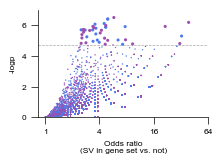

In [21]:
palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

# only show gene sets that have an odds ratio slanted towards cases
coding_results = gse_results.query('sv_category == "coding" & odds_ratio_cases > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases"])

fig4b_data = coding_results.query('category == "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
fig4b_data['size'] = np.where(fig4b_data['y_baseline'] > nlp_bonf, 5, 1)
fig4b_data['c'] = fig4b_data['disease'].replace(palette)

# plot the significant ones first
sig = fig4b_data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

# labeled_sig = sig[sig['gs'].isin(labeled_gs)]
# points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = fig4b_data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

fig.savefig('figures/fig4b.pdf')

In [22]:
sig[lambda row: row['gs'].isin(labeled_gs)][['disease', 'gs', 'odds_ratio_cases', 'p_cases', 'odds_ratio_controls', 'p_controls']]

,disease,gs,odds_ratio_cases,p_cases,odds_ratio_controls,p_controls
30240,ewing,calcium ion homeostasis (GO:0055074),7.223916,1.754506e-05,2.508260,0.000002
31835,ewing,peptide biosynthetic process (GO:0043043),4.515146,7.819402e-07,2.265941,0.000003
842923,neuroblastoma,positive regulation of synaptic transmission (...,38.760736,6.660950e-07,5.893217,0.000028
843865,neuroblastoma,central nervous system development (GO:0007417),3.120968,2.227406e-06,1.709969,0.000005


This figure is then hand-labeled in illustrator.

# Visualize some case-control odds ratios

The above figure focuses on significant gene sets in the broadest category (reflecting an "enrichment" of SVs in these gene sets). To help control for underlying confounders (genomic position, CG content, etc), we can compare to controls.

There are a few category-gene set pairs that we'll highlight.

In [23]:
category_geneset_pairs = [['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                         ]

category_geneset_pairs = np.array(category_geneset_pairs)

We also add a calculation for the odds ratio confidence intervals.

In [24]:
import statsmodels.api as sm

In [25]:
def calculate_or_ci(row):
    
    results = []
    for cohort in ['cases', 'controls']:
        top_row = np.array(row[f'cat_freq_{cohort}'].split('/')).astype(int)
        bottom_row = np.array(row[f'ref_freq_{cohort}'].split('/')).astype(int)
        
        # adjust to actual counts
        top_row[1] = top_row[1] - top_row[0]
        bottom_row[1] = bottom_row[1] - bottom_row[0]
        
        table = np.array([top_row, bottom_row]).astype(int) + 1
        
        # statsmodels will return a confidence interval for the odds ratio
        table = sm.stats.Table2x2(table)
        
        odds = table.log_oddsratio
        ci = table.log_oddsratio_confint()
        
        results += [odds] + list(ci)
        
    return results

In [26]:
plot_results = []
log_odds_ratio_intervals = []

# calculate odds ratio intervals for all our chosen geneset-category pairs
for dz, cat, gs in category_geneset_pairs:
    res = gse_results[lambda row: (row['disease'] == dz) & 
                               (row['category'] == cat) & 
                               (row['gs'] == gs) & 
                               (row['sv_category'] == "coding")]

    assert len(res) == 1
    
    log_odds_ratios = calculate_or_ci(res.iloc[0])
    log_odds_ratio_intervals.append(log_odds_ratios)
    
    plot_results.append(res)
    
plot_results = pd.concat(plot_results).reset_index()

# convert from ln to log2
log_odds_ratio_intervals = log_odds_ratio_intervals / np.log(2)

plot_results[['cases_logor', 'cases_logor_upper', 'cases_logor_lower', 'controls_logor', 
              'controls_logor_upper', 'controls_logor_lower']] = log_odds_ratio_intervals

In [27]:
plot_results[['disease', 'category', 'gs', 'ref_freq_cases', 'cat_freq_cases', 'odds_ratio_cases', 'p_cases', 'cases_logor']]

,disease,category,gs,ref_freq_cases,cat_freq_cases,odds_ratio_cases,p_cases,cases_logor
0,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,central nervous system development (GO:0007417),63/3158,49/823,3.120968,2.227406e-06,1.641993
1,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,central nervous system development (GO:0007417),75/3412,37/569,3.131332,1.360310e-06,1.646777
2,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,central nervous system development (GO:0007417),90/3714,22/267,3.724426,3.157001e-06,1.897018
3,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,positive regulation of synaptic transmission (...,0/3158,9/823,38.760736,6.660950e-07,5.276524
4,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,positive regulation of synaptic transmission (...,2/3412,7/569,16.156306,3.263876e-05,4.014025
5,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,positive regulation of synaptic transmission (...,6/3714,3/267,7.997844,1.850863e-02,2.999611
6,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,calcium ion homeostasis (GO:0055074),6/3086,13/865,7.223916,1.754506e-05,2.852781
7,ewing,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,calcium ion homeostasis (GO:0055074),12/3358,7/593,3.508845,1.614209e-02,1.810996
8,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skel...,calcium ion homeostasis (GO:0055074),16/3711,3/240,3.653979,1.045290e-01,1.869468
9,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,peptide biosynthetic process (GO:0043043),20/3086,25/865,4.515146,7.819402e-07,2.174773


And plot

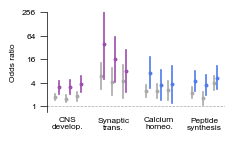

In [28]:
fig, ax = plt.subplots(1, figsize = (2.3, 1.3)) 

# python doesn't make these plots super easy to make, so we make it "manually"
x = 0
xticks = []

# plot each geneset-category along the x axis
for index, row in plot_results.iterrows():
    dz = row['disease']
    
    # plot cases and controls next to each other
    for cohort in ['controls', 'cases']:
        
        color = palette[dz] if cohort == "cases" else "darkgrey"
        
        y_val = row[f'{cohort}_logor']
        y_upper = row[f'{cohort}_logor_upper']
        y_lower = row[f'{cohort}_logor_lower']
        ax.scatter([x], [y_val], s = 4, color = color)
        ax.plot([x, x], [y_upper, y_lower], color = color)
    
        if cohort == 'controls':
            xticks.append(x + 0.4)

        x += 0.8

    x += 1
    
    if (index + 1) % 3 == 0:
        x += 3
        
ax.set_yticks([-2, 0, 2, 4, 6, 8])
ax.set_yticklabels([0.25, 1, 4, 16, 64, 256])
ax.set_ylim([-0.5, 8])
ax.axhline(y = 0, color = 'darkgrey', linestyle = 'dashed', zorder = -1, linewidth = 0.5)
aesthetics.strip_axis(ax, x = 'label', y = 'ignore')
ax.set_ylabel('Odds ratio')
ax.set_xticks(xticks[1::3])
ax.set_xticklabels(['CNS\ndevelop.', 'Synaptic\ntrans.', 'Calcium\nhomeo.', 'Peptide\nsynthesis'], fontsize = 6)

fig.savefig('figures/fig4c.pdf')

# Show the relationship between gene sets

For the supplement, we show some gene set results as heatmaps--reflecting the inherently correlated nature of many gene sets.

In [29]:
sig_gene_sets = {}
for disease in ['ewing', 'neuroblastoma']:
    sig_categories = framework_results.query(
        f'sv_category == "coding" & disease == "{disease}" & af_category == "singleton"' 
    ).sort_values(by = 'p_value').head(30)
    
    sig_categories = list(
        sig_categories["disease"] + " | " + sig_categories["category_name"]
    )

    heatmap_data = coding_results.copy()
    heatmap_data["disease_category"] = (
        heatmap_data["disease"] + " | " + heatmap_data["category"]
    )
    heatmap_data = heatmap_data[heatmap_data["disease_category"].isin(sig_categories)]

    gene_sets_to_show = heatmap_data[
        (heatmap_data["y_baseline"] > -np.log10(0.05 / num_gene_sets)) & \
        (heatmap_data['x_baseline'] > 0)
    ]

    gene_sets_to_show = gene_sets_to_show['gs'].value_counts()

    # only show hits significant in at least 2 categories
    gene_sets_to_show = list(gene_sets_to_show[gene_sets_to_show > 1].index)
    
    if disease == 'ewing':
        gene_sets_to_show += ['calcium ion homeostasis (GO:0055074)']
    
    sig_gene_sets[disease] = gene_sets_to_show
    
    print(disease, len(gene_sets_to_show))

ewing 26
neuroblastoma 34


Make the heatmaps

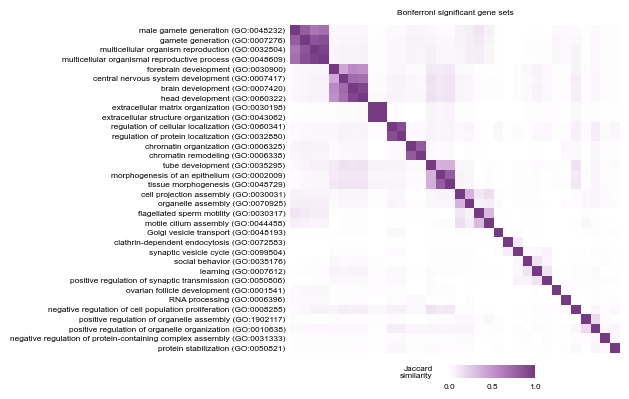

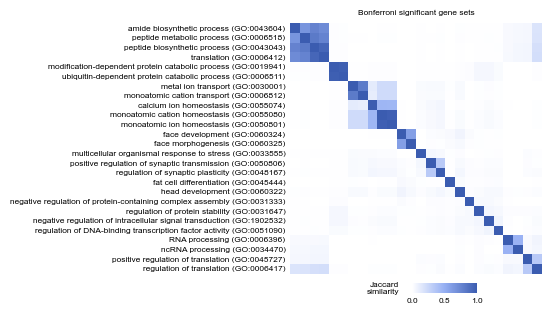

In [30]:
jaccard_matrices = {}
for disease in ['neuroblastoma', 'ewing']:
    
    gene_sets_to_show = sig_gene_sets[disease]

    gs_list = []
    genes_list = []

    for gs, genes in gene_sets.items():
        if gs not in gene_sets_to_show:
            continue
        gs_list += [gs] * len(genes)
        genes_list += genes

    gs_gene_matrix = pd.DataFrame()
    gs_gene_matrix["gs"] = gs_list
    gs_gene_matrix["gene"] = genes_list
    gs_gene_matrix["value"] = 1

    gs_gene_matrix = (
        gs_gene_matrix.pivot(columns="gs", index="gene", values="value").fillna(0).T
    )

    data_values = gs_gene_matrix.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    Z = linkage(j_dist, method="average")
    ordered_indices = leaves_list(Z)

    ordered_gs = gs_gene_matrix.index[ordered_indices]

    j_dist = j_dist[ordered_indices, :][:, ordered_indices]
    j_dist = pd.DataFrame(j_dist, index=ordered_gs, columns=ordered_gs);
    
    # make the color map
    custom_cmap = colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette[disease]['light2'], mc.palette[disease]['dark1']], N = 256)
    
    fig, ax = plt.subplots(1, figsize=np.array([0.125, 0.125]) * len(ordered_gs))
    sns.heatmap(j_dist, annot=False, cmap=custom_cmap, cbar=False)
    ax.set_yticks(np.array(range(len(ordered_gs))) + 0.5)
    ax.set_yticklabels(ordered_gs, fontsize = 6, va = 'center')
    ax.set_xticklabels([])
    ax.tick_params(axis = 'both', length = 0)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.text(s = 'Bonferroni significant gene sets', x = 0.5, y = 1.03, transform = ax.transAxes, ha = 'center', va = 'bottom')
    
    # add the colorbar
    cb = mpl.cm.ScalarMappable(cmap=custom_cmap)

    cbar_ax = fig.add_axes([0.5, 0.05, 0.2, 0.03])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(size=0)
    cbar.outline.set_visible(False)
    cbar_ax.text(s = 'Jaccard\nsimilarity', x = -0.2, y = 0.5, ha = 'right', va = 'center')
    
    fig.savefig(f'figures/{disease}-gene-set-similarity-supplement.pdf', bbox_inches = 'tight')